# ***Bridging the Gap in Text-Based Emotion Detection - SemEval 2025 Task 11***

# Multilingual Emotion Detection - Track A (5 Languages, Mixed Label Configurations)

This implementation uses **XLM-RoBERTa** to perform multi-label emotion detection for 5 languages. The code handles datasets with different label configurations and adapts the training process accordingly.


In [ ]:
import torch
# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    hamming_loss, precision_recall_fscore_support,
    label_ranking_average_precision_score, accuracy_score
)
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm
from torch.nn import BCEWithLogitsLoss

# Load and Normalize Data

In [ ]:
df = pd.read_csv("afr.csv")
df.head()

,id,text,anger,disgust,fear,joy,sadness
0,afr_train_track_a_00001,Ons sal gesondheidsprogramme in skole herinstel.,0,0,0,1,0
1,afr_train_track_a_00002,Ons moet verstaan dat ons in landbou een groot...,0,0,0,1,0
2,afr_train_track_a_00003,Hulle is die trots van die Boland en hulle hoo...,0,0,0,1,0
3,afr_train_track_a_00004,Ek sou nog baie voorbeelde vir u kon noem.,0,0,0,0,0
4,afr_train_track_a_00005,In ons bedryf loon dit gewoonlik om geduldig t...,0,0,0,1,0


In [ ]:
df = pd.read_csv("amh.csv")
df.head()

,id,text,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,amh_train_track_a_00001,እንኳን እግዚአብሔር ረዳችህ ::: ልጅ ማለት እንዲህ ነው : በደስታችሁ ...,0,0,0,1,0,0
1,amh_train_track_a_00002,ቴፊክ ነፍስ ይማር አቃጥለኸንም አልቀረህ ተገላገልን በስተመጨረሻ እስኪ ደ...,0,0,0,1,0,0
2,amh_train_track_a_00003,ብዙ ሰዎች ለጋሱን ያቈላምጣሉ፥ ስጦታ ለሚሰጥም ሁሉ ወዳጅ ነው። ድሀን ሰ...,0,0,0,0,0,0
3,amh_train_track_a_00004,ከምናወራው እንደው ጥቂቷን ብንኖራት ባይ ነኝ ይሄ የሱን ደጋፊዎችም ያካት...,1,0,0,0,0,0
4,amh_train_track_a_00005,ይህንን xx ሰው ብለሽ ማነጋገርሽ የሚገርም ነው።,0,1,0,0,0,1


In [ ]:
df = pd.read_csv("deu.csv")
df.head()

,id,text,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,deu_train_track_a_00001,"Nein nein nix da, fuck den schön weiter ab bis...",1,0,0,0,0,0
1,deu_train_track_a_00002,Vor 100 Jahren ging man auf die Strasse weil m...,1,1,0,0,0,0
2,deu_train_track_a_00003,Wann endlich Gabby Epstein heiraten,0,0,0,0,0,0
3,deu_train_track_a_00004,"Wegen dem Song 1001 Nacht, dem einen Phantomto...",0,0,0,1,0,0
4,deu_train_track_a_00005,"Dann sollten wir versuchen, sie zu erreichen. ...",0,0,0,0,0,0


In [ ]:
df = pd.read_csv("eng.csv")
df.head()

,id,text,Anger,Fear,Joy,Sadness,Surprise
0,eng_train_track_a_00001,But not very happy.,0,0,1,1,0
1,eng_train_track_a_00002,Well she's not gon na last the whole song like...,0,0,1,0,0
2,eng_train_track_a_00003,She sat at her Papa's recliner sofa only to mo...,0,0,0,0,0
3,eng_train_track_a_00004,"Yes, the Oklahoma city bombing.",1,1,0,1,1
4,eng_train_track_a_00005,They were dancing to Bolero.,0,0,1,0,0


In [ ]:
df = pd.read_csv("oro.csv")
df.head()

,id,text,Anger,Disgust,Fear,Joy,Sadness,Surprise
0,oro_train_track_a_00001,Tolli Nagaan jibbamee Garee tplf n jalqabame U...,0,0,1,0,0,0
1,oro_train_track_a_00002,Hojiii gaaariii asumaaan garakos kota ijole kenya,0,0,0,1,0,0
2,oro_train_track_a_00003,Haaayeee nuuufi jirrraaadhaaa,0,0,0,1,0,0
3,oro_train_track_a_00004,Dhira Mohammmed Deksiso Baga bate Gazexeeesss...,0,0,0,1,0,0
4,oro_train_track_a_00005,Iluu Abbaa Booraa OromiyaaFinca'aa Soor URL,0,0,0,0,0,0


In [ ]:
# Define file paths for the datasets
file_paths = {
    "afr": "afr.csv",
    "amh": "amh.csv",
    "deu": "deu.csv",
    "eng": "eng.csv",
    "oro": "oro.csv"
}

# Define emotion labels
emotion_columns = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']
datasets = []

for lang, file_path in file_paths.items():
    df = pd.read_csv(file_path)
    df.columns = [col.lower() for col in df.columns]  # Normalize column names

    # Ensure all emotion columns exist
    for col in emotion_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing columns with 0

    # Retain only the required columns
    df = df[['text'] + emotion_columns]
    datasets.append(df)

# Combine all datasets into a single DataFrame
df_full = pd.concat(datasets, ignore_index=True)

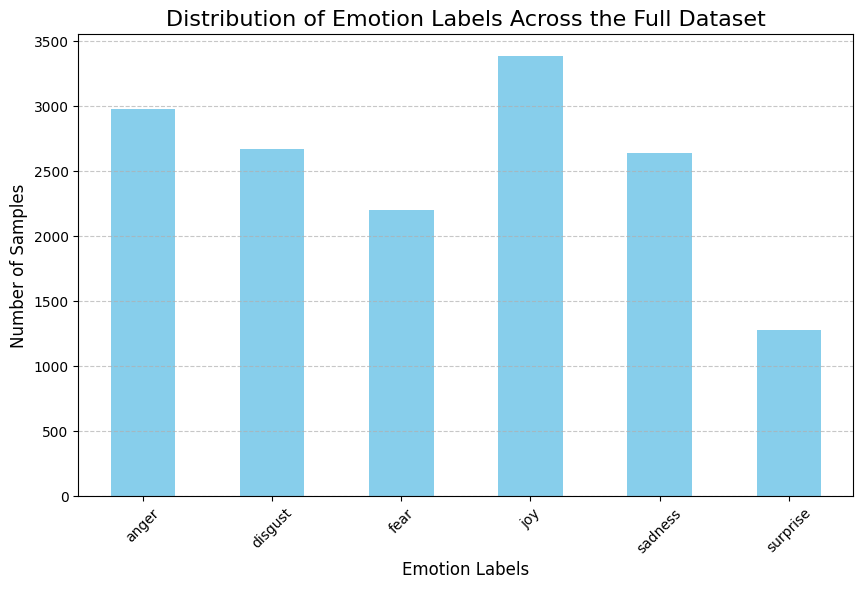

In [ ]:
import matplotlib.pyplot as plt

# Sum up the total occurrences of each emotion label
label_counts = df_full[emotion_columns].sum()

# Plot the distribution of class labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Emotion Labels Across the Full Dataset", fontsize=16)
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Print exact counts for reference
print("Class Label Distribution:")
print(label_counts)

Class Label Distribution:
anger       2979
disgust     2669
fear        2203
joy         3386
sadness     2640
surprise    1278
dtype: int64


# Preprocess Data

In [ ]:
# Split data into features (X) and labels (y)
X = df_full['text'].fillna("")
y = df_full[emotion_columns]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Load tokenizer and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", num_labels=len(emotion_columns), problem_type="multi_label_classification"
).to(device)

# Tokenize text data
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts.tolist(), padding=True, truncation=True,
        max_length=max_length, return_tensors="pt"
    )

# Tokenize training and testing data
train_encodings = tokenize_texts(X_train, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

# Convert data into DataLoader format
train_dataset = TensorDataset(
    train_encodings['input_ids'], train_encodings['attention_mask'],
    torch.tensor(y_train.values, dtype=torch.float32)
)
test_dataset = TensorDataset(
    test_encodings['input_ids'], test_encodings['attention_mask'],
    torch.tensor(y_test.values, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Training Components

In [ ]:
# Define class weights to handle label imbalance
class_weights = 1.0 / y_train.sum(axis=0).iloc[:]  # Use .iloc for positional indexing
class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float32).to(device)

# Define loss function
loss_fn = BCEWithLogitsLoss(pos_weight=class_weights)

# Define optimizer and learning rate scheduler
from torch.optim import AdamW  # Use PyTorch's AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

epochs = 20
num_training_steps = len(train_loader) * epochs
lr_scheduler = get_scheduler(
    "linear", optimizer=optimizer, num_warmup_steps=int(0.1 * num_training_steps), num_training_steps=num_training_steps
)

<ipython-input-9-8c012e50aac6>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  class_weights = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float32).to(device)


In [ ]:
# Define early stopping mechanism
class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.counter = 0

    def check(self, score):
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.counter = 0
            return False  # Do not stop
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
        return False

early_stopping = EarlyStopping(patience=3)

# Define Training and Evaluation Functions

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, device, threshold=0.5):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits)
            preds = (probs > threshold).float()

            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()

    hamming = hamming_loss(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro')
    lrap = label_ranking_average_precision_score(all_labels, all_probs)
    accuracy = accuracy_score(all_labels, all_preds)

    print(f"\nEvaluation Metrics:\nHamming Loss: {hamming:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}\nLRAP: {lrap:.4f}\nAccuracy: {accuracy:.4f}")
    return {'hamming_loss': hamming, 'precision': precision, 'recall': recall, 'f1': f1, 'lrap': lrap, 'accuracy': accuracy}

In [ ]:
# Training function
def train_model(model, train_loader, test_loader, optimizer, loss_fn, lr_scheduler, epochs, early_stopping, threshold=0.5):
    """
    Train the model with tracking and display metrics.

    Parameters:
        model: PyTorch model to train.
        train_loader: DataLoader for the training dataset.
        test_loader: DataLoader for the test dataset.
        optimizer: Optimizer for the model parameters.
        loss_fn: Loss function.
        lr_scheduler: Learning rate scheduler.
        epochs: Number of epochs.
        early_stopping: EarlyStopping object to prevent overfitting.
        threshold: Threshold for label assignment during evaluation.

    Returns:
        metrics: Dictionary of metrics for each epoch.
    """
    train_losses = []
    val_f1_scores = []
    metrics_per_epoch = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for input_ids, attention_mask, labels in loop:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Loss: {avg_train_loss:.4f}")

        # Evaluate the model
        metrics = evaluate_model(model, test_loader, device, threshold=threshold)
        val_f1_scores.append(metrics['f1'])
        metrics_per_epoch.append(metrics)

        print(f"Validation Metrics:\n"
              f"  F1-Score: {metrics['f1']:.4f}\n"
              f"  Hamming Loss: {metrics['hamming_loss']:.4f}\n"
              f"  Precision: {metrics['precision']:.4f}\n"
              f"  Recall: {metrics['recall']:.4f}\n"
              f"  LRAP: {metrics['lrap']:.4f}\n"
              f"  Accuracy: {metrics['accuracy']:.4f}")

        # Early stopping
        if early_stopping.check(metrics['f1']):
            print("Early stopping triggered.")
            break

    # Return training losses and metrics per epoch for further analysis
    return {
        'train_losses': train_losses,
        'val_f1_scores': val_f1_scores,
        'metrics_per_epoch': metrics_per_epoch
    }

# Train the Model

In [ ]:
# Train the model and retrieve metrics
results = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    lr_scheduler=lr_scheduler,
    epochs=epochs,
    early_stopping=early_stopping,
    threshold=0.5  # Custom threshold for predictions
)

Epoch 1/20: 100%|██████████| 680/680 [04:34<00:00,  2.48it/s, loss=0.083]


Epoch 1 Loss: 0.2358


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Hamming Loss: 0.1857
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
LRAP: 0.6732
Accuracy: 0.2043
Validation Metrics:
  F1-Score: 0.0000
  Hamming Loss: 0.1857
  Precision: 0.0000
  Recall: 0.0000
  LRAP: 0.6732
  Accuracy: 0.2043


Epoch 2/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0862]


Epoch 2 Loss: 0.1117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Evaluation Metrics:
Hamming Loss: 0.1857
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
LRAP: 0.7621
Accuracy: 0.2043
Validation Metrics:
  F1-Score: 0.0000
  Hamming Loss: 0.1857
  Precision: 0.0000
  Recall: 0.0000
  LRAP: 0.7621
  Accuracy: 0.2043


Epoch 3/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0552]


Epoch 3 Loss: 0.1023

Evaluation Metrics:
Hamming Loss: 0.1856
Precision: 1.0000
Recall: 0.0010
F1-Score: 0.0020
LRAP: 0.8095
Accuracy: 0.2046
Validation Metrics:
  F1-Score: 0.0020
  Hamming Loss: 0.1856
  Precision: 1.0000
  Recall: 0.0010
  LRAP: 0.8095
  Accuracy: 0.2046


Epoch 4/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.225]


Epoch 4 Loss: 0.0902

Evaluation Metrics:
Hamming Loss: 0.1673
Precision: 0.8886
Recall: 0.1133
F1-Score: 0.2009
LRAP: 0.8387
Accuracy: 0.2698
Validation Metrics:
  F1-Score: 0.2009
  Hamming Loss: 0.1673
  Precision: 0.8886
  Recall: 0.1133
  LRAP: 0.8387
  Accuracy: 0.2698


Epoch 5/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.108]


Epoch 5 Loss: 0.0793

Evaluation Metrics:
Hamming Loss: 0.1490
Precision: 0.8339
Recall: 0.2470
F1-Score: 0.3811
LRAP: 0.8420
Accuracy: 0.3493
Validation Metrics:
  F1-Score: 0.3811
  Hamming Loss: 0.1490
  Precision: 0.8339
  Recall: 0.2470
  LRAP: 0.8420
  Accuracy: 0.3493


Epoch 6/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0702]


Epoch 6 Loss: 0.0692

Evaluation Metrics:
Hamming Loss: 0.1422
Precision: 0.7765
Recall: 0.3293
F1-Score: 0.4624
LRAP: 0.8507
Accuracy: 0.3739
Validation Metrics:
  F1-Score: 0.4624
  Hamming Loss: 0.1422
  Precision: 0.7765
  Recall: 0.3293
  LRAP: 0.8507
  Accuracy: 0.3739


Epoch 7/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0459]


Epoch 7 Loss: 0.0607

Evaluation Metrics:
Hamming Loss: 0.1417
Precision: 0.8149
Recall: 0.3068
F1-Score: 0.4458
LRAP: 0.8501
Accuracy: 0.3717
Validation Metrics:
  F1-Score: 0.4458
  Hamming Loss: 0.1417
  Precision: 0.8149
  Recall: 0.3068
  LRAP: 0.8501
  Accuracy: 0.3717


Epoch 8/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0264]


Epoch 8 Loss: 0.0542

Evaluation Metrics:
Hamming Loss: 0.1300
Precision: 0.7701
Recall: 0.4280
F1-Score: 0.5502
LRAP: 0.8664
Accuracy: 0.4295
Validation Metrics:
  F1-Score: 0.5502
  Hamming Loss: 0.1300
  Precision: 0.7701
  Recall: 0.4280
  LRAP: 0.8664
  Accuracy: 0.4295


Epoch 9/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0611]


Epoch 9 Loss: 0.0489

Evaluation Metrics:
Hamming Loss: 0.1326
Precision: 0.7710
Recall: 0.4069
F1-Score: 0.5326
LRAP: 0.8565
Accuracy: 0.4218
Validation Metrics:
  F1-Score: 0.5326
  Hamming Loss: 0.1326
  Precision: 0.7710
  Recall: 0.4069
  LRAP: 0.8565
  Accuracy: 0.4218


Epoch 10/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00626]


Epoch 10 Loss: 0.0427

Evaluation Metrics:
Hamming Loss: 0.1309
Precision: 0.8070
Recall: 0.3880
F1-Score: 0.5241
LRAP: 0.8647
Accuracy: 0.4126
Validation Metrics:
  F1-Score: 0.5241
  Hamming Loss: 0.1309
  Precision: 0.8070
  Recall: 0.3880
  LRAP: 0.8647
  Accuracy: 0.4126


Epoch 11/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0497]


Epoch 11 Loss: 0.0375

Evaluation Metrics:
Hamming Loss: 0.1255
Precision: 0.7671
Recall: 0.4657
F1-Score: 0.5795
LRAP: 0.8581
Accuracy: 0.4494
Validation Metrics:
  F1-Score: 0.5795
  Hamming Loss: 0.1255
  Precision: 0.7671
  Recall: 0.4657
  LRAP: 0.8581
  Accuracy: 0.4494


Epoch 12/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0318]


Epoch 12 Loss: 0.0345

Evaluation Metrics:
Hamming Loss: 0.1261
Precision: 0.7448
Recall: 0.4888
F1-Score: 0.5902
LRAP: 0.8651
Accuracy: 0.4494
Validation Metrics:
  F1-Score: 0.5902
  Hamming Loss: 0.1261
  Precision: 0.7448
  Recall: 0.4888
  LRAP: 0.8651
  Accuracy: 0.4494


Epoch 13/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0319]


Epoch 13 Loss: 0.0300

Evaluation Metrics:
Hamming Loss: 0.1245
Precision: 0.7617
Recall: 0.4802
F1-Score: 0.5890
LRAP: 0.8636
Accuracy: 0.4512
Validation Metrics:
  F1-Score: 0.5890
  Hamming Loss: 0.1245
  Precision: 0.7617
  Recall: 0.4802
  LRAP: 0.8636
  Accuracy: 0.4512


Epoch 14/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0843]


Epoch 14 Loss: 0.0270

Evaluation Metrics:
Hamming Loss: 0.1292
Precision: 0.7516
Recall: 0.4548
F1-Score: 0.5667
LRAP: 0.8501
Accuracy: 0.4310
Validation Metrics:
  F1-Score: 0.5667
  Hamming Loss: 0.1292
  Precision: 0.7516
  Recall: 0.4548
  LRAP: 0.8501
  Accuracy: 0.4310


Epoch 15/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00576]


Epoch 15 Loss: 0.0248

Evaluation Metrics:
Hamming Loss: 0.1244
Precision: 0.7395
Recall: 0.5099
F1-Score: 0.6036
LRAP: 0.8590
Accuracy: 0.4545
Validation Metrics:
  F1-Score: 0.6036
  Hamming Loss: 0.1244
  Precision: 0.7395
  Recall: 0.5099
  LRAP: 0.8590
  Accuracy: 0.4545


Epoch 16/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00355]


Epoch 16 Loss: 0.0216

Evaluation Metrics:
Hamming Loss: 0.1242
Precision: 0.7241
Recall: 0.5357
F1-Score: 0.6158
LRAP: 0.8556
Accuracy: 0.4634
Validation Metrics:
  F1-Score: 0.6158
  Hamming Loss: 0.1242
  Precision: 0.7241
  Recall: 0.5357
  LRAP: 0.8556
  Accuracy: 0.4634


Epoch 17/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00158]


Epoch 17 Loss: 0.0190

Evaluation Metrics:
Hamming Loss: 0.1219
Precision: 0.7272
Recall: 0.5502
F1-Score: 0.6264
LRAP: 0.8596
Accuracy: 0.4744
Validation Metrics:
  F1-Score: 0.6264
  Hamming Loss: 0.1219
  Precision: 0.7272
  Recall: 0.5502
  LRAP: 0.8596
  Accuracy: 0.4744


Epoch 18/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00482]


Epoch 18 Loss: 0.0177

Evaluation Metrics:
Hamming Loss: 0.1208
Precision: 0.7379
Recall: 0.5419
F1-Score: 0.6249
LRAP: 0.8561
Accuracy: 0.4748
Validation Metrics:
  F1-Score: 0.6249
  Hamming Loss: 0.1208
  Precision: 0.7379
  Recall: 0.5419
  LRAP: 0.8561
  Accuracy: 0.4748


Epoch 19/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.00943]


Epoch 19 Loss: 0.0166

Evaluation Metrics:
Hamming Loss: 0.1219
Precision: 0.7313
Recall: 0.5429
F1-Score: 0.6232
LRAP: 0.8566
Accuracy: 0.4707
Validation Metrics:
  F1-Score: 0.6232
  Hamming Loss: 0.1219
  Precision: 0.7313
  Recall: 0.5429
  LRAP: 0.8566
  Accuracy: 0.4707


Epoch 20/20: 100%|██████████| 680/680 [04:35<00:00,  2.47it/s, loss=0.0196]


Epoch 20 Loss: 0.0155

Evaluation Metrics:
Hamming Loss: 0.1216
Precision: 0.7347
Recall: 0.5406
F1-Score: 0.6229
LRAP: 0.8599
Accuracy: 0.4726
Validation Metrics:
  F1-Score: 0.6229
  Hamming Loss: 0.1216
  Precision: 0.7347
  Recall: 0.5406
  LRAP: 0.8599
  Accuracy: 0.4726
Early stopping triggered.


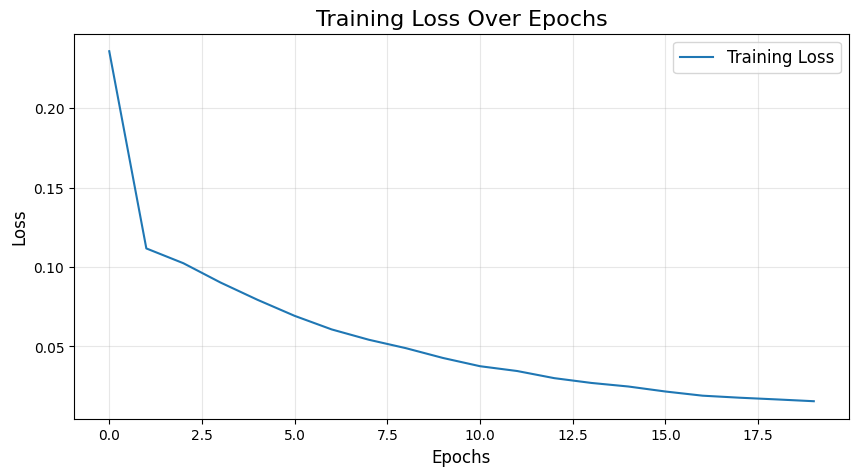

In [ ]:
# Visualize Training Loss and Validation F1-Score
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(results['train_losses'], label='Training Loss')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

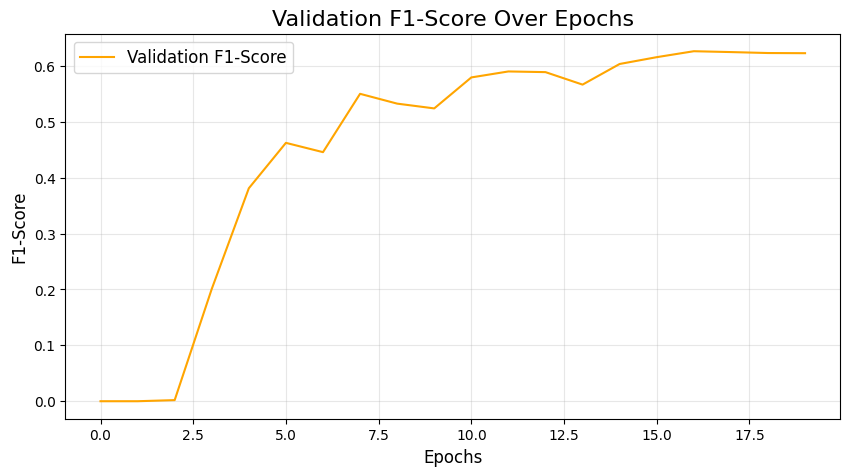

In [ ]:
# Plot Validation F1-Score
plt.figure(figsize=(10, 5))
plt.plot(results['val_f1_scores'], label='Validation F1-Score', color='orange')
plt.title('Validation F1-Score Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

In [ ]:
# Print Final Metrics
final_metrics = results['metrics_per_epoch'][-1]
print("\nFinal Evaluation Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Final Evaluation Metrics:
Hamming_loss: 0.1216
Precision: 0.7347
Recall: 0.5406
F1: 0.6229
Lrap: 0.8599
Accuracy: 0.4726


# Predictions for Unlabeled Data

In [ ]:
# Function to make predictions on a new dataset
def predict_labels(model, tokenizer, file_path, output_path, device, threshold=0.5):
    """
    Predict labels for an unlabeled dataset and save results.

    Parameters:
        model: Trained model.
        tokenizer: Pre-trained tokenizer used for encoding text.
        file_path: Path to the input CSV file containing the 'text' column.
        output_path: Path to save the output CSV file with predictions.
        device: Device to perform computations (CPU/GPU).
        threshold: Threshold for label assignment.
    """
    # Load the dataset
    df = pd.read_csv(file_path)
    if 'text' not in df.columns:
        raise ValueError("The dataset must contain a 'text' column.")

    # Tokenize the text
    print(f"Tokenizing {len(df)} samples for prediction...")
    encodings = tokenizer(
        df['text'].fillna("").tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move input data to device
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Predict in batches
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), 16), desc="Predicting"):
            batch_ids = input_ids[i:i+16]
            batch_mask = attention_mask[i:i+16]
            outputs = model(batch_ids, attention_mask=batch_mask)
            probs = torch.sigmoid(outputs.logits)  # Convert logits to probabilities
            preds = (probs > threshold).float().cpu().numpy()  # Apply threshold
            predictions.extend(preds)

    # Prepare results
    predictions = np.array(predictions)
    df[emotion_columns] = predictions
    print(f"Saving predictions to {output_path}...")
    df.to_csv(output_path, index=False)
    print(f"Predictions saved successfully!")

In [ ]:
# Example: Make predictions for 'eng_a.csv'
predict_labels(
    model=model,
    tokenizer=tokenizer,
    file_path="eng_a.csv",  # Path to the input CSV
    output_path="eng_a_predictions.csv",  # Path to save predictions
    device=device,
    threshold=0.5  # Threshold for assigning labels
)

Tokenizing 116 samples for prediction...


Predicting: 100%|██████████| 8/8 [00:00<00:00, 16.67it/s]


Saving predictions to eng_a_predictions.csv...
Predictions saved successfully!


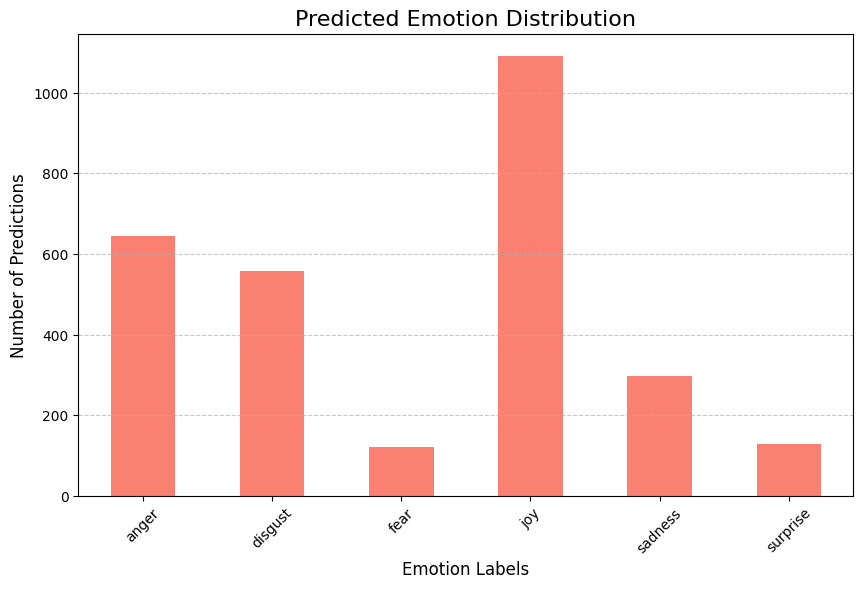

Predicted Emotion Counts:
anger        646
disgust      557
fear         123
joy         1091
sadness      298
surprise     129
dtype: int64


In [ ]:
# Analyze predictions
predicted_counts = df[emotion_columns].sum()

# Plot predicted emotion distribution
plt.figure(figsize=(10, 6))
predicted_counts.plot(kind='bar', color='salmon')
plt.title("Predicted Emotion Distribution", fontsize=16)
plt.xlabel("Emotion Labels", fontsize=12)
plt.ylabel("Number of Predictions", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Print exact counts for predictions
print("Predicted Emotion Counts:")
print(predicted_counts)